In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy Look-Up Tables

**Recommended datasample(s):**
- ``gamma-1`` for training (goes into energy training)
- ``gamma-2`` for testing (goes into classification training in the reference analysis since we use estimated energy as one of the model's features)

**Data level(s):** DL1b (telescope-wise image parameters) + DL2a (only shower geometry)

**Description:**

An alternative to more complex machine learning approaches, this LUT allows to estimate the energy of a test event by assigning an average value based on true energy of a training event with some of its reconstructed image parameters and shower geometry.

Basically, given intensity and impact parameter of every image/shower pair we build a LUT using true energy as a weight.

At a fixed true energy we expect that intensity of the image drops down with increasing impact parameter.

**Requirements and steps to reproduce:**

To run this notebook you will need TRAINING files generated using ``protopipe-TRAINING``.  
The data format required to run the notebook is the current one used by _protopipe_.  

To get a filled notebook and reproduce these results,

- get the necessary input files using ``protopipe-TRAINING`` (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL2_EnergyLUT``

To obtain the list of all available parameters add ``--help-notebook``.

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

**Notes:** this could be technically merged into the "to_energy-estimation" notebook, since it uses the same (training) data, but it's also a nice check on its own.

## Table of contents

- [LUTs from training sample](#LUTs-from-training-sample)
- [Use these LUTs to predict the reconstructed energy](#Use-these-LUTs-to-predict-the-reconstructed-energy)
  - [Re-apply them first to the train sample](#Re-apply-them-first-to-the-train-sample)
  - [Predict the reconstructed energy of the test sample](#Predict-the-reconstructed-energy-of-the-test-sample)
      - [Migration matrix](#Migration-matrix)
      - [Energy bias and resolution](#Energy-bias-and-resolution)
      - [Dispersion matrix with bias and resolution](#Dispersion-matrix-with-bias-and-resolution)

## Imports

In [2]:
import os
from pathlib import Path
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.interpolate import RectBivariateSpline
import tables
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# font size
font_size = 16

# Set general font size
plt.rcParams['font.size'] = font_size

from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type

## Functions

In [3]:
def create_lookup_function(binned_stat):
    """
    Returns a function f(x,y) that evaluates the lookup at a point.
    """
    cx = 0.5 * (binned_stat.x_edge[0:-1] + binned_stat.x_edge[1:])
    cy = 0.5 * (binned_stat.y_edge[0:-1] + binned_stat.y_edge[1:])
    z = binned_stat.statistic
    z[~np.isfinite(z)] = 0  # make sure there are no infs or nans
    interpolator = RectBivariateSpline(x=cx, y=cy, z=z, kx=1, ky=1, s=0)
    return lambda x,y : interpolator.ev(x,y) # go back to TeV and evaluate

## Input data

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the container
analyses_directory = "" # host directory containing 'shared_folder'
output_directory = Path.cwd() # default output directory for plots
analysis_name = ""# Name of the analysis
infile_train = None
infile_test = None

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = ""
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_directory_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": "DL3",
}
load_EventDisplay = True
EventDisplay_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203"
input_simtel_file = "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
input_filenames = {
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
if not infile_train:
    try:
        infile_train = input_filenames["TRAINING_energy_gamma"]
    except (NameError, KeyError):
        infile_train = "TRAINING_energy_tail_gamma_merged.h5"

if not infile_test:
    try:
        infile_test = input_filenames["TRAINING_classification_gamma"]
    except (NameError, KeyError):
        infile_test = "TRAINING_classification_tail_gamma_merged.h5"

In [7]:
train_path = Path("data/TRAINING/for_energy_estimation")
test_path = Path("data/TRAINING/for_particle_classification")

indir_train = Path(analyses_directory) / analysis_name / train_path
indir_test = Path(analyses_directory) / analysis_name / test_path

In [8]:
cameras = get_camera_names(input_directory = indir_train,
                           file_name = infile_train)
data_train = read_protopipe_TRAINING_per_tel_type(input_directory = indir_train,
                                                  file_name = infile_train,
                                                  camera_names=cameras)       

In [9]:
intensity = {}
impact_distance = {}
true_energy = {}

In [10]:
# select only successfully reconstructed showers from good images
valid_showers_train = {}
for camera in cameras:
    valid_showers_train[camera] = data_train[camera][(data_train[camera]["is_valid"]==True) 
                                                     & (data_train[camera]["good_image"]==1)]

In [11]:
for camera in cameras:
    
    intensity[camera] = valid_showers_train[camera]["hillas_intensity_reco"]
    impact_distance[camera] = valid_showers_train[camera]["impact_dist"]
    true_energy[camera] = valid_showers_train[camera]["true_energy"]

In [12]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

## LUTs from training sample
[back to top](#Table-of-contents)

Few things to notice for interpreting these LUTs:

- for a fixed intensity, the energy should increase with impact distance because far away showers are fainter,
- any tail in the low-intensity-high-impact regime is (at least) a sign of mis-reconstruction of the shower geometry,
- in the high-intensity-high-impact regime there should be no data, since it's too below the intensity threshold to be triggered

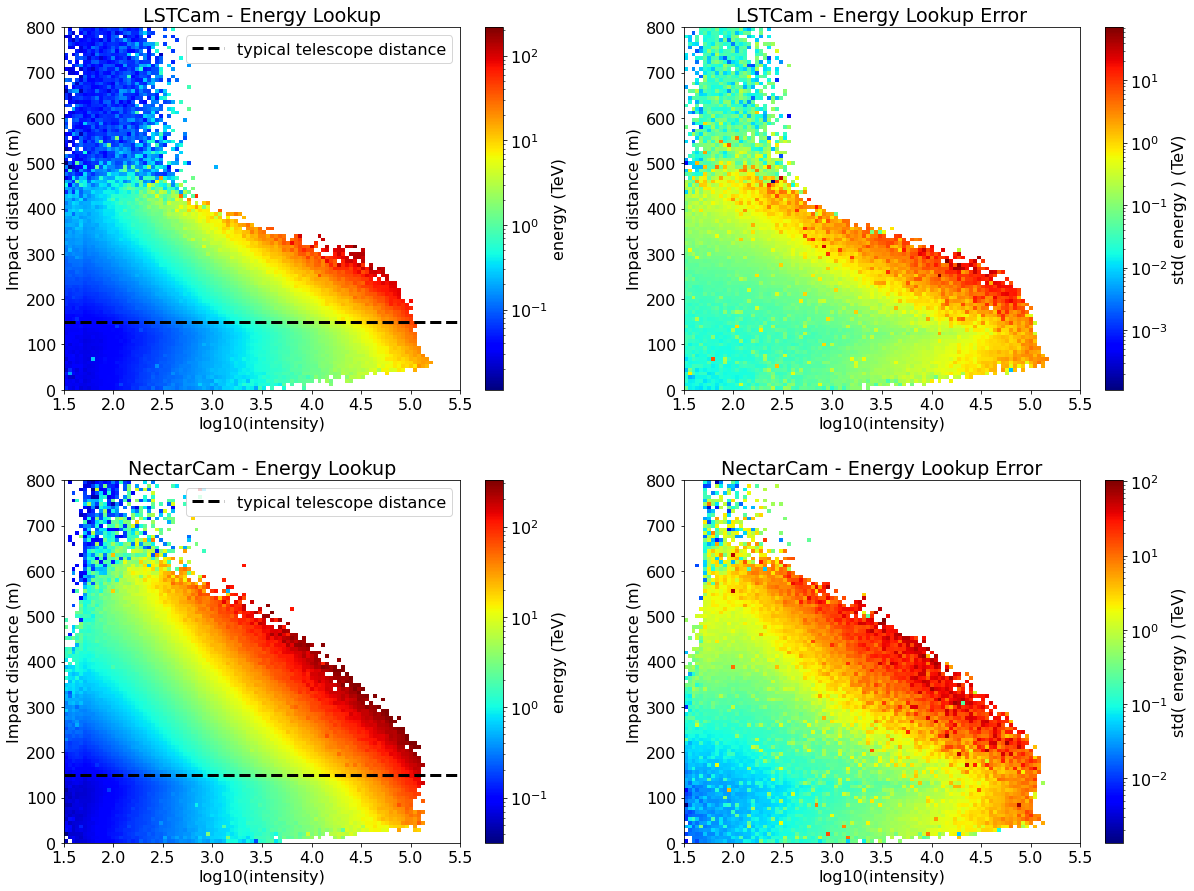

In [13]:
fig = plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

hist_geom = dict(bins=[100, 100],
                 range=[[1.5, 5.5],  # log10(intensity)
                        [0.0, 800]]) # impact distance
energy_LUT = {}
energy_LUT_errors = {}

for i, camera in enumerate(cameras):
    
    plt.subplot(2, 2, i*2 + 1)

    energy_LUT[camera] = binned_statistic_2d(
        x=np.log10(intensity[camera]),
        y=impact_distance[camera],
        values=true_energy[camera],
        statistic="mean",
        **hist_geom
    )
        
    plt.pcolormesh(
        energy_LUT[camera].x_edge,
        energy_LUT[camera].y_edge,
        energy_LUT[camera].statistic.T,
        norm=LogNorm(),
        cmap="jet",
        )
    plt.title(f"{camera} - Energy Lookup")
    plt.ylabel("Impact distance (m)")
    plt.xlabel("log10(intensity)")
    plt.colorbar(label="energy (TeV)")
    plt.axhline(150, ls='--', lw=3, color="black", label="typical telescope distance")
    plt.legend()
        
    plt.subplot(2, 2, i*2 + 2)

    energy_LUT_errors[camera] = binned_statistic_2d(
        x=np.log10(intensity[camera]),
        y=impact_distance[camera],
        values=true_energy[camera],
        statistic="std",
        **hist_geom
    )
        
    plt.pcolormesh(
        energy_LUT_errors[camera].x_edge,
        energy_LUT_errors[camera].y_edge,
        energy_LUT_errors[camera].statistic.T,
        norm=LogNorm(),
        cmap="jet",
        )
    plt.title(f"{camera} - Energy Lookup Error")
    plt.ylabel("Impact distance (m)")
    plt.xlabel("log10(intensity)")
    plt.colorbar(label="std( energy ) (TeV)")
    
    plt.savefig(plots_folder / f"EnergyLUT_{camera}_protopipe_{analysis_name}.png")
    
plt.show()

## Use these LUTs to predict the reconstructed energy
[back to top](#Table-of-contents)

We should expect that the migration matrix and it's benchmark energy resolution and bias are less then or at least similar to what we get from the ML model.

In [14]:
# Get an energy estimator for each camera

energy_estimator = {}

for camera in cameras:
    
    energy_estimator[camera] = create_lookup_function(energy_LUT[camera])

### Re-apply them first to the train sample
[back to top](#Table-of-contents)

The difference between the energy reconstructed with the LUT and the originally binned data should be mostly 0, apart where the error is very high or where relevant DL1 parameters are undefined (but we cut those here).

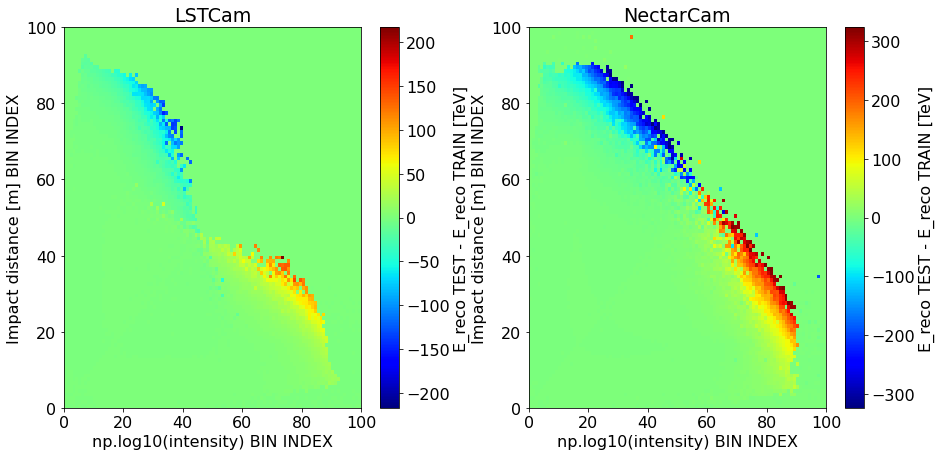

In [15]:
fig = plt.figure(figsize=(15, 7))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)

    cx = 0.5*(energy_LUT[camera].x_edge[0:-1] +  energy_LUT[camera].x_edge[1:])
    cy = 0.5*(energy_LUT[camera].y_edge[0:-1] +  energy_LUT[camera].y_edge[1:])
    mx, my = np.meshgrid(cx,cy)
    reco_energy = energy_estimator[camera](mx,my)
    plt.pcolormesh(reco_energy - energy_LUT[camera].statistic, cmap='jet')
    cb = plt.colorbar()
    cb.set_label("E_reco TEST - E_reco TRAIN [TeV]")
    plt.title(camera)
    plt.xlabel("np.log10(intensity) BIN INDEX")
    plt.ylabel("Impact distance [m] BIN INDEX")
    
    plt.savefig(plots_folder / f"EnergyLUT_test_on_train_{camera}_protopipe_{analysis_name}.png")
    
plt.show()

### Predict the reconstructed energy of the test sample
[back to top](#Table-of-contents)

To be compared with the plots from the DL2 "to classification" notebook

In [16]:
data_test = read_protopipe_TRAINING_per_tel_type(input_directory = indir_test,
                                                  file_name = infile_test,
                                                  camera_names=cameras) 

In [17]:
# we select also in this case only events which passed the cuts in the pipeline
# select only successfully reconstructed showers from good images
valid_showers_test = {}
for camera in cameras:
    valid_showers_test[camera] = data_test[camera][(data_test[camera]["is_valid"]==True) 
                                                     & (data_test[camera]["good_image"]==1)].copy()

In [18]:
for camera in cameras:

    valid_showers_test[camera]["reco_energy_LUT"] = energy_estimator[camera](np.log10(valid_showers_test[camera]["hillas_intensity_reco"]),
                                                                             valid_showers_test[camera]["impact_dist"])

#### Migration matrix
[back to top](#Table-of-contents)

/var/folders/2z/142033n17rbfy969s6h4hymw0000gn/T/ipykernel_41897/4227825085.py:11: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(unique_all_valid_showers_test["reco_energy_LUT"].values)


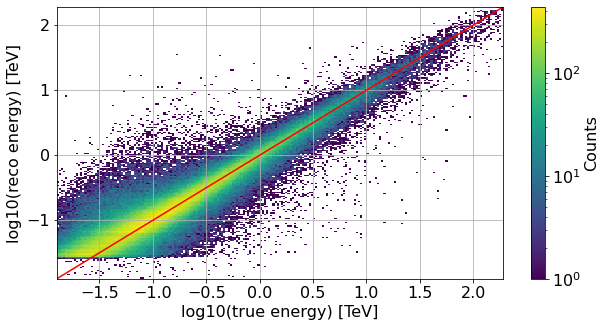

In [19]:
# merge the tables from test data
for i, camera in enumerate(cameras):
    if i==0:
        all_valid_showers_test = valid_showers_test[camera]
    else:
        all_valid_showers_test = all_valid_showers_test.append(valid_showers_test[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_all_valid_showers_test = all_valid_showers_test.drop_duplicates(subset=['event_id'])

x = np.log10(unique_all_valid_showers_test["true_energy"].values)
y = np.log10(unique_all_valid_showers_test["reco_energy_LUT"].values)

bin_edges = np.arange(-1.9, 2.3, 1/50)

plt.figure(figsize=(10,5))

plt.hist2d(x, y, bins=[bin_edges, bin_edges], norm=LogNorm())
plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('log10(reco energy) [TeV]')

plt.plot(bin_edges, bin_edges, color="red")

plt.savefig(plots_folder / f"EnergyLUT_migration_matrix_{camera}_protopipe_{analysis_name}.png")
    
plt.show()

None # to remove clutter by mpl objects

#### Energy bias and resolution
[back to top](#Table-of-contents)

Considering the distribution,

``x = (E_reco / E_true) - 1``

**Energy bias** as the ``mean of x``, also in bins of true energy.We plot the **bias** as the ``mean of (Erec/Etrue-1)``, also in bins of true energy.

**Energy resolution** is here calculated in bins of true energy
- as the ``68%-quantile of the distribution of abs(x)``. 

Note that by using this definition, any possible reconstruction bias is "absorbed" in the resolution.

- as the same quantity, but bias-corrected as ``68%-quantile of the distribution of abs(x - bias)``

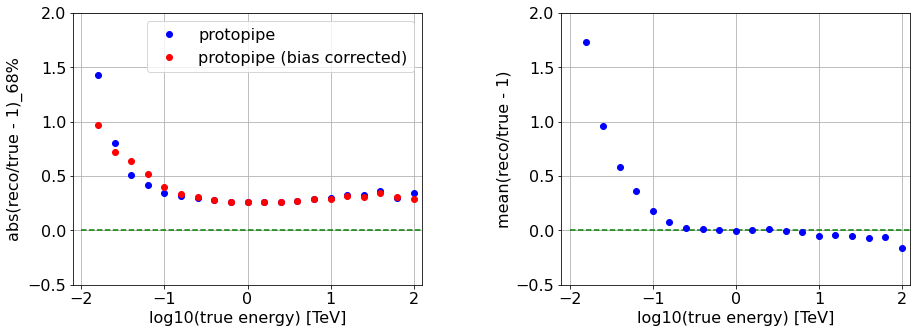

In [20]:
reco = unique_all_valid_showers_test["reco_energy_LUT"].values
true = unique_all_valid_showers_test["true_energy"].values

# from CTAMARS data
bin_edges_x = np.array([-1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,
        0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,  2.3])

plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace = 0.4)
font_size = 16

# RESOLUTION

plt.subplot(1,2,1)

# Set tick font size
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)

resolution = binned_statistic(np.log10(true),
                              reco/true - 1,
                              statistic = lambda x: np.percentile(np.abs(x), 68),
                              bins=bin_edges_x,)

corr_resolution = binned_statistic(np.log10(true),
                                  reco/true - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                  bins=bin_edges_x)


plt.plot(0.5*(bin_edges_x[:-1]+bin_edges_x[1:]), resolution[0], "bo", label="protopipe")
plt.plot(0.5*(bin_edges_x[:-1]+bin_edges_x[1:]), corr_resolution[0], "ro", label="protopipe (bias corrected)")

plt.hlines(0.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], ls="--", color="green")

plt.grid(which="both", axis="both")
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('abs(reco/true - 1)_68%')
plt.xlim(-2.1, 2.1)
plt.ylim(-0.5, 2)
plt.legend(loc="best")

# BIAS

plt.subplot(1,2,2)

# Set tick font size
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(font_size)

bias = binned_statistic(np.log10(true), 
                        reco/true - 1, 
                        statistic="mean", 
                        bins=bin_edges_x)


plt.plot(0.5*(bin_edges_x[:-1]+bin_edges_x[1:]), bias[0], "bo")
plt.hlines(0.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], ls="--", color="green")

plt.grid(which="both", axis="both")
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('mean(reco/true - 1)')
plt.xlim(-2.1, 2.1)
plt.ylim(-0.5, 2)

plt.savefig(plots_folder / f"EnergyLUT_resolution_bias_{camera}_protopipe_{analysis_name}.png")
    
plt.show()

None # to remove clutter by mpl objects

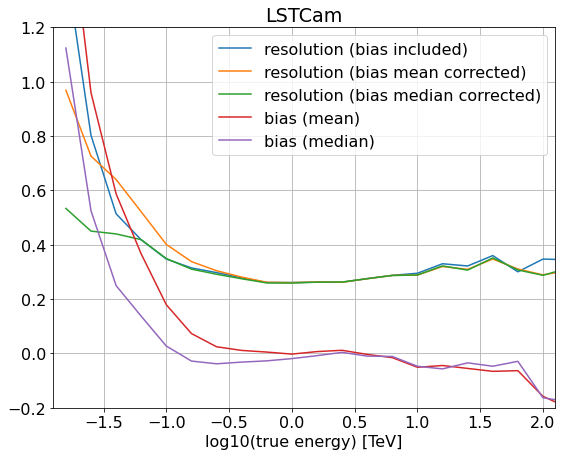

<Figure size 432x288 with 0 Axes>

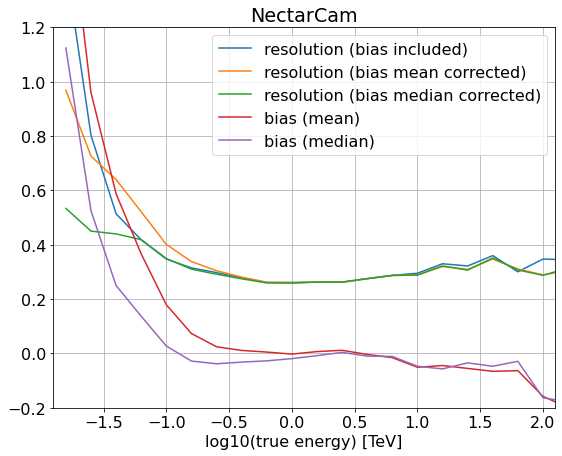

<Figure size 432x288 with 0 Axes>

In [21]:
true_energy_bins_edges = bin_edges_x
true_energy_bins_centers = 0.5 * (true_energy_bins_edges[1:]+true_energy_bins_edges[:-1])

for camera in cameras:
    
    plt.figure(figsize=(9,7))
    
    resolution = binned_statistic(np.log10(true),
                              reco/true - 1,
                              statistic = lambda x: np.percentile(np.abs(x), 68),
                              bins=true_energy_bins_edges)

    corr_resolution_mean = binned_statistic(np.log10(true),
                                  reco/true - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                  bins=true_energy_bins_edges)
    
    corr_resolution_median = binned_statistic(np.log10(true),
                                  reco/true - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.median(x)), 68),
                                  bins=true_energy_bins_edges)
    
    bias_mean = binned_statistic(np.log10(true), 
                        reco/true - 1, 
                        statistic="mean", 
                        bins=true_energy_bins_edges)
    
    bias_median = binned_statistic(np.log10(true), 
                        reco/true - 1, 
                        statistic="median", 
                        bins=true_energy_bins_edges)
    
    plt.plot(true_energy_bins_centers, resolution[0], label="resolution (bias included)")
    plt.plot(true_energy_bins_centers, corr_resolution_mean[0], label="resolution (bias mean corrected)")
    plt.plot(true_energy_bins_centers, corr_resolution_median[0], label="resolution (bias median corrected)")
    plt.plot(true_energy_bins_centers, bias_mean[0], label="bias (mean)")
    plt.plot(true_energy_bins_centers, bias_median[0], label="bias (median)")
    plt.title(camera)
    plt.legend()
    plt.grid()
    plt.ylim(-0.2, 1.2)
    plt.xlim(np.log10(0.0125), np.log10(125))
    plt.xlabel('log10(true energy) [TeV]')
    
    plt.show()
    plt.savefig(plots_folder / f"energy_LUT_resolution_bias_{camera}_protopipe_{analysis_name}.png")

#### Dispersion matrix with bias and resolution
[back to top](#Table-of-contents)

Here the error bar is the bias-corrected resolution.  

The dispersion matrix has been normalized to ensure that the integral probability of reconstructing a photon with a certain true energy at a certain reconstructed energy is 1.0

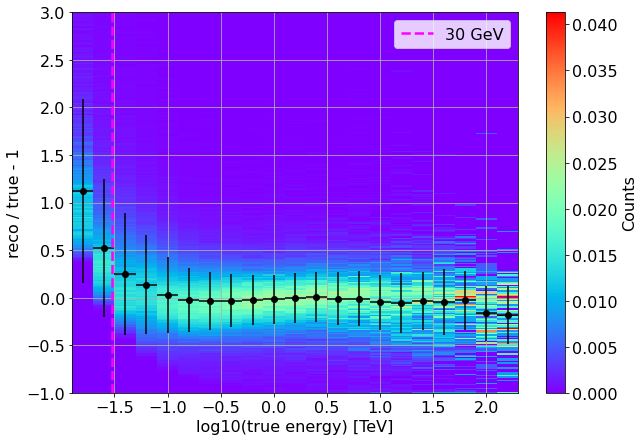

In [22]:
x = np.log10(true)
y = reco/true - 1

bin_edges_y = np.linspace(-1,3,300)

plt.figure(figsize=(10,7))

h, _, _ = np.histogram2d(x, y, bins=[bin_edges_x, bin_edges_y])
# normalize y-axis so to get a max probability of 1 within 1 bin in true energy
h = h/np.sum(h, axis=1)[np.newaxis].T
# re-plot
plt.pcolormesh(bin_edges_x, bin_edges_y, h.T, cmap="rainbow")


corr_resolution = binned_statistic(np.log10(true),
                                  reco/true - 1,
                                  statistic = lambda x: np.percentile(np.abs(x-np.mean(x)), 68),
                                  bins=bin_edges_x)

bias = binned_statistic(np.log10(true), 
                        reco/true -1, 
                        statistic="median", 
                        bins=bin_edges_x)

plt.errorbar(x = 0.5*(bin_edges_x[:-1]+bin_edges_x[1:]),
             y = bias[0],
             xerr = np.diff(bin_edges_x)/2,
             yerr = corr_resolution[0],
             ls="none",
             fmt = "o",
            color="black")

plt.vlines(np.log10(0.03), plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], ls="--", lw=2.5, color="magenta", label="30 GeV")

plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('reco / true - 1')
plt.legend()

plt.savefig(plots_folder / f"EnergyLUT_Dispersion_resolution_bias_{camera}_protopipe_{analysis_name}.png")
    
plt.show()

None # to remove clutter by mpl objects